In [337]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [338]:
# from google.colab import drive
# drive.mount('/content/drive')

# Lectura de datos

In [339]:
# DIR = "/content/drive/MyDrive/Data Mining Properati/"
#df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
#df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
df_test = pd.read_feather('bases/properati_a_predecir.ftr').set_index('id')
df_train = pd.read_feather('bases/properati_entrenamiento.ftr').set_index('id')

# df_test = pd.read_feather(DIR+'properati_a_predecir.ftr').set_index('id')
# df_train = pd.read_feather(DIR+'properati_entrenamiento.ftr').set_index('id')
# df_test.head()

# Entendimiento (magia parte 1 -- AID)

# Limpieza y transformación de datos (magia parte 2 -- MD)

In [340]:
raro = df_test['surface_total']<df_test['surface_covered']

df_test.loc[raro,'surface_total'], df_test.loc[raro,'surface_covered'] = df_test.loc[raro,'surface_covered'], df_test.loc[raro,'surface_total']

raro = df_train['surface_total']<df_train['surface_covered']

df_train.loc[raro,'surface_total'], df_train.loc[raro,'surface_covered'] = df_train.loc[raro,'surface_covered'], df_train.loc[raro,'surface_total']

In [341]:
en_amba_train = (df_train.lat>-60)&(df_train['lon']>-35.5)&(df_train['lon']<-34)& (df_train.lat<-56.5) & (df_train.l1=='Argentina')
en_amba_test  =  (df_test.lat>-60)&(df_test['lon']>-35.5)&(df_test['lon']<-34)& (df_test.lat<-56.5) & (df_test.l1=='Argentina')

# en_ballester = ((df_train.title.str.upper().str.contains('BALLESTER')) | (df_train.description.str.upper().str.contains('BALLESTER'))&
#                 en_amba_train)
# ballester = df_train[en_ballester]

no_lugares = ['Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste']

#Filtramos los que se encuentran dentro del rango de AMBA y que no son del conurbano
df_train = df_train[en_amba_train & (~df_train.l2.isin(no_lugares))]

#Pulimos la zona circundante a la plata para que coincida con el test
df_train = df_train[(df_train.l2=='Capital Federal')|((df_train.l2=='Buenos Aires Interior')&(df_train.lat>-58.15)&(df_train.lon<-34.7)&(df_train.lon>-35.1))]

# df_train = pd.concat((df_train,ballester),axis=0)

df_train = df_train[(df_train.price_period=='Mensual')|(df_train.price_period.isnull())] #TODO ver si sacarlo 

df_train.loc[df_train.l2=='Buenos Aires Interior','l2'] = 'Bs.As. G.B.A. Zona Sur'

df_train = df_train[df_train.operation_type=='Venta']

df_test.loc[df_test.title.str.contains('en Las Cañitas'),'l3'] = "Las Cañitas"
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas')) & (df_test.lat<-58.4),'lat'] = np.nan

df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.47),'l3'] = 'Villa Urquiza'
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.44),['lat','lon']] = np.nan

df_train = df_train[df_train.property_type.isin(['PH','Departamento'])]

df_train = df_train[df_train.currency=='USD'] #saco tambien los nulos porque no tienen precio

df_train.shape

(102477, 24)

In [342]:
# df_test[~en_amba_test & (df_test.lat.notna()) & (df_test.l3.isna())][['title','description','l1','l2','l3','l4']].title.unique()

In [343]:
df_test.loc[~en_amba_test,['lat','lon']] = np.nan

In [344]:
cols_a_imputar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','lat','lon']
# crear nuevas columnas para indicar los valores imputados
for column in cols_a_imputar:
    is_imputed_train = np.where(df_train[column].isnull(), True, False)
    is_imputed_test = np.where(df_test[column].isnull(), True, False)
    df_train[column + '_imputed'] = is_imputed_train
    df_test[column + '_imputed'] = is_imputed_test

In [345]:
#df_train['train_test'] = 'train'
#df_test['train_test'] = 'test'

#df = pd.concat((df_train,df_test),axis=0)

#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(dos|2) baños'))   ,'bathrooms'] = 2
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(tres|3) baños'))  ,'bathrooms'] = 3
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cuatro|4) baños')),'bathrooms'] = 4
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cinco|5) baños')) ,'bathrooms'] = 5
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(seis|6) baños'))  ,'bathrooms'] = 6
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('baño(\ |\.|\,)'))  ,'bathrooms'] = 1

#df_train = df[df.train_test=='train']
#df_test = df[df.train_test=='test']

#df_train.drop(columns='train_test',inplace=True)
#df_test.drop(columns='train_test',inplace=True)

In [346]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [347]:
imp = IterativeImputer(max_iter=20, random_state=42)  # tiene add_indicator

grupo_columnas = [['rooms','bedrooms','bathrooms','surface_total','surface_covered'],['lat','lon']]
for lista_columnas in grupo_columnas:
    df_train[lista_columnas] = imp.fit_transform(df_train[lista_columnas])
    df_test[lista_columnas] = imp.transform(df_test[lista_columnas])

In [348]:
df_test.rooms      = df_test.rooms.astype('int')
df_train.rooms     = df_train.rooms.astype('int')
df_test.bedrooms   = df_test.bedrooms.astype('int')
df_train.bedrooms  = df_train.bedrooms.astype('int')
df_test.bathrooms  = df_test.bathrooms.astype('int')
df_train.bathrooms = df_train.bathrooms.astype('int')

## Filtrado

In [349]:
pd.concat((df_train.property_type.value_counts(dropna=False),
           df_test.property_type.value_counts(dropna=False)),axis=1).sort_index()

,property_type,property_type
Departamento,92599,5426
PH,9878,574


In [350]:
pd.concat((df_train.bathrooms.value_counts(dropna=False),
           df_test.bathrooms.value_counts(dropna=False)),axis=1)

,bathrooms,bathrooms
1,68986,4605.0
2,22962,1227.0
3,6732,144.0
4,2188,20.0
0,860,NaN
5,588,1.0
6,107,3.0
7,20,NaN
8,9,NaN
16,4,NaN


In [351]:
df_train = df_train[(df_train['bathrooms']<=10) | (df_train['bathrooms'].isnull())]
df_train.shape

(102458, 31)

In [352]:
pd.concat((df_train.rooms.value_counts(dropna=False),
           df_test.rooms.value_counts(dropna=False)),axis=1).sort_index()

,rooms,rooms
1,20683,NaN
2,30539,2984.0
3,26686,3016.0
4,17708,NaN
5,4634,NaN
6,1301,NaN
7,491,NaN
8,263,NaN
9,46,NaN
10,48,NaN


In [353]:
df_train = df_train[((df_train.rooms<4)&((df_train.rooms>1))) |(df_train.rooms.isnull())]
df_train.shape

(57225, 31)

In [354]:
pd.concat((df_train.bedrooms.value_counts(dropna=False),
           df_test.bedrooms.value_counts(dropna=False)),axis=1).sort_index()

,bedrooms,bedrooms
0,18.0,3.0
1,32743.0,3268.0
2,24233.0,2704.0
3,223.0,23.0
4,5.0,1.0
5,NaN,1.0
11,2.0,NaN
15,1.0,NaN


In [355]:
df_train.loc[df_train.bedrooms==-1,'bedrooms'] = 0
# df_train = df_train[(df_train.bedrooms<6) |(df_train.bedrooms.isnull())]
df_train.shape

(57225, 31)

<AxesSubplot: xlabel='surface_covered'>

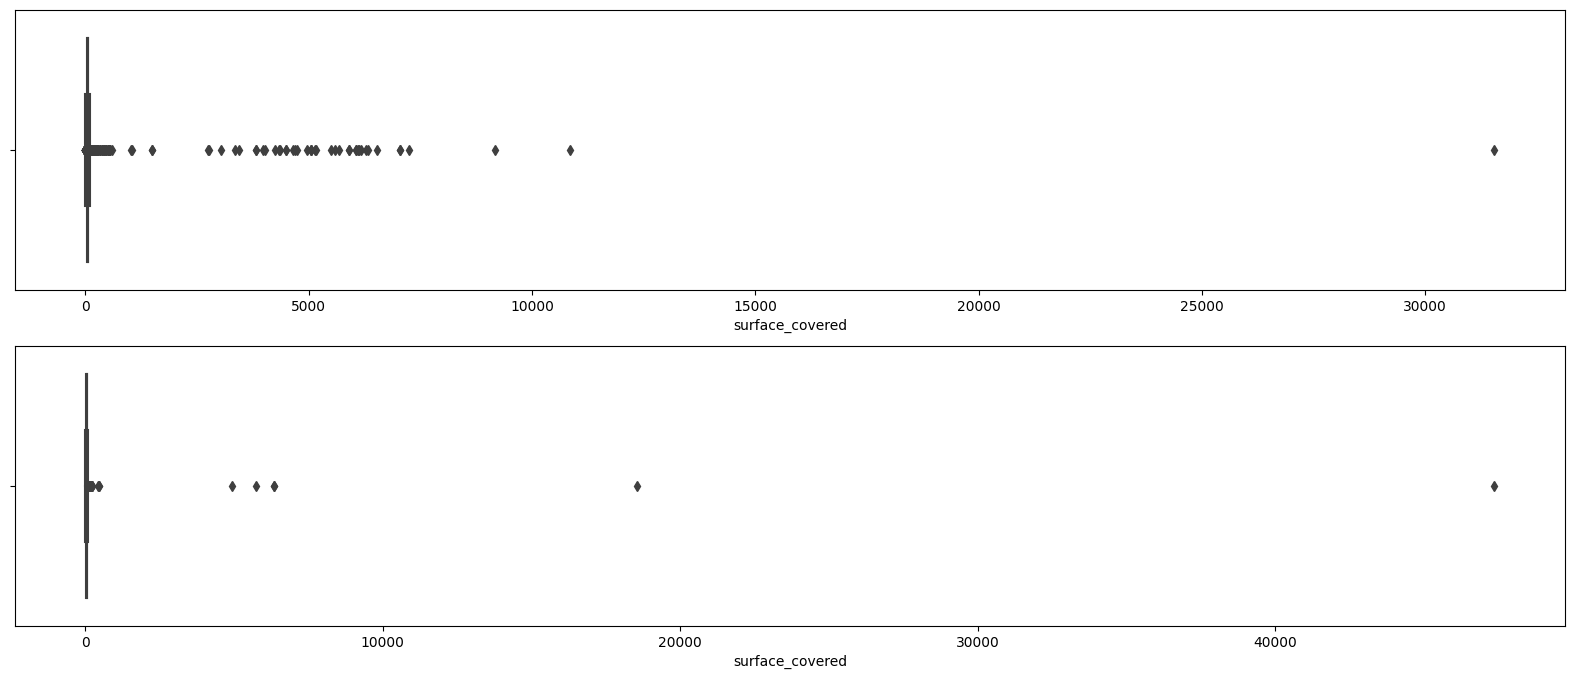

In [356]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_covered',ax=ax[0])
sns.boxplot(data=df_test,x='surface_covered',ax=ax[1])

In [357]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,57225.0,65.412454,198.519329,1.0,45.0,56.353441,72.000000,31550.0
surface_total,57225.0,82.632708,579.201816,0.0,50.0,67.000000,84.679193,108960.0


In [358]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.651663,672.817535,10.0,45.0,56.353441,73.0000,47360.0
surface_total,6000.0,91.493766,751.472659,21.0,51.0,68.000000,84.7017,47360.0


In [359]:
df_train = df_train[((df_train['surface_covered']>=40)&(df_train['surface_covered']<100))]#|(df_train['surface_covered'].isnull())]
df_train.shape

(46439, 31)

<AxesSubplot: xlabel='surface_total'>

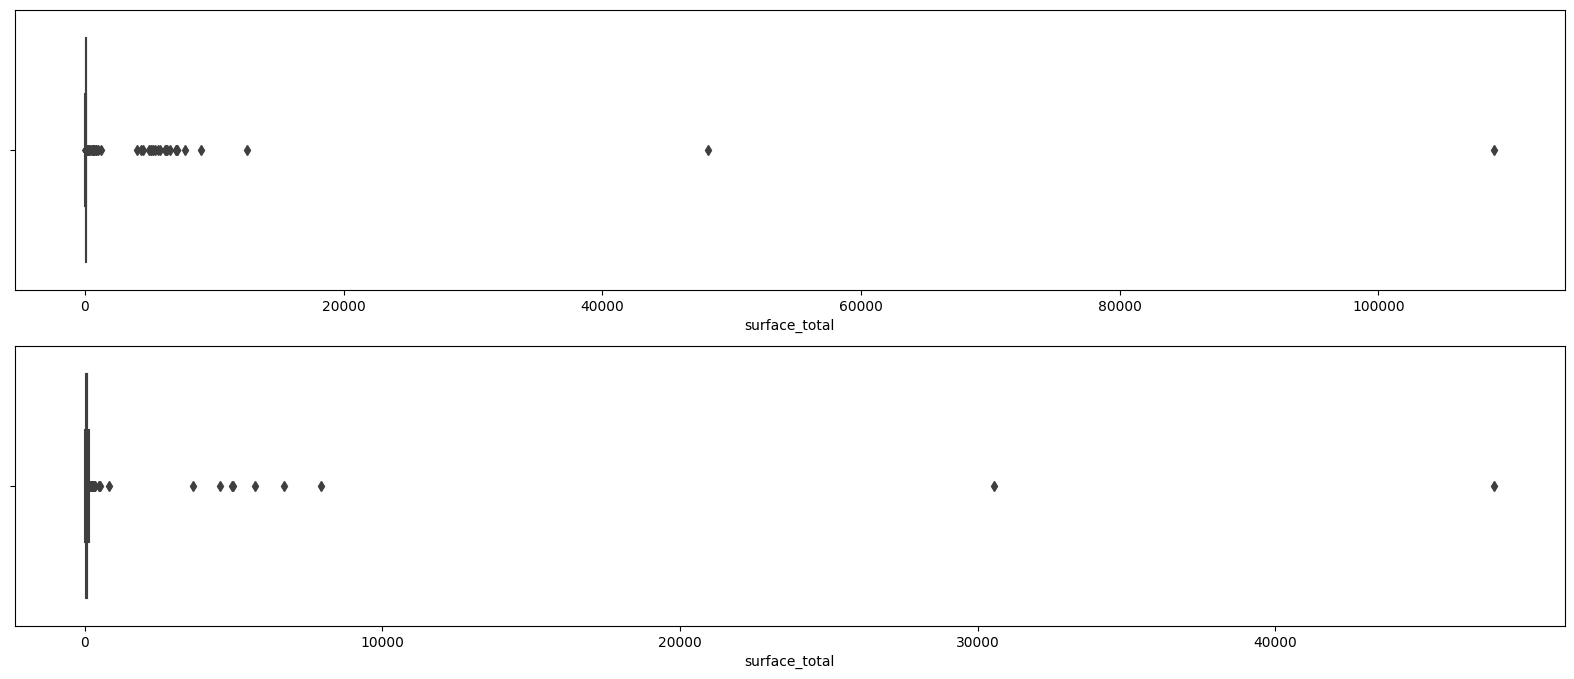

In [360]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_total',ax=ax[0])
sns.boxplot(data=df_test,x='surface_total',ax=ax[1])

In [361]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,46439.0,61.552309,15.662004,40.0,49.0,58.696586,71.329284,99.915411
surface_total,46439.0,78.607536,570.158722,40.0,55.0,69.775073,84.000000,108960.000000


In [362]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.651663,672.817535,10.0,45.0,56.353441,73.0000,47360.0
surface_total,6000.0,91.493766,751.472659,21.0,51.0,68.000000,84.7017,47360.0


In [363]:
df_train = df_train[((df_train['surface_total']>=50)&(df_train['surface_total']<100))|(df_train['surface_total'].isnull())]
df_train.shape

(33599, 31)

In [364]:
pd.concat((df_train[['surface_covered','surface_total']].describe().T,
           df_test[['surface_covered','surface_total']].describe().T),axis=0)

,count,mean,std,min,25%,50%,75%,max
surface_covered,33599.0,60.854979,11.768355,40.0,52.0,59.000000,68.956069,99.000000
surface_total,33599.0,69.581796,12.962513,50.0,59.0,69.775073,78.000000,99.920485
surface_covered,6000.0,76.651663,672.817535,10.0,45.0,56.353441,73.000000,47360.000000
surface_total,6000.0,91.493766,751.472659,21.0,51.0,68.000000,84.701700,47360.000000


## Imputación de nulos

## Armado de variables

In [365]:
df = pd.concat((df_train,df_test),axis=0)

df['bathrooms_rooms'] = df['bathrooms']/df['rooms']
df['bedrooms_rooms'] = df['bedrooms']/df['rooms']
df['covered'] = df['surface_covered']/df['surface_total']

df['start_year']  = pd.to_datetime(df['start_date']).dt.year
df['start_month'] = pd.to_datetime(df['start_date']).dt.month
df['start_day'] = pd.to_datetime(df['start_date']).dt.month

df['tiene_esp_abierto'] = 0
df.loc[(df['surface_total']-df['surface_covered'])!=0,'tiene_esp_abierto'] = 1

df['description'] = df["description"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')
#df['title'] = df["title"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')

for c in ["barrio privado", "corredor",'suite','monoambiente','amueblado',
          'ascensor','parrilla','patio','balcon','jardin','linea (a|b|b|c|d|e|h)',
          'obelisco','catedral','metrobus','barrancas','barrio chino','river',
          'universidad','facultad','subte','tren','estacion','museo','parque','jacuzzi',
          '(j|y)acu(z|zz)i','sho(pp|p)ing','country','terminal','avenida','av.','av',
          'expensa','expensas','a(mm|m)enities','inmobiliaria','dueñ(o|a) direct(o|a)',
          'balcon','pileta|piscina','escuela|colegio','centro','microcentro','lago','estilo franc(é|e)s',
          'libertador','baulera','hotel','emprendimiento']:
    df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
    #df[f"title_{c}"] = df["title"].str.contains(c,regex=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9356\2069691848.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9356\2069691848.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9356\2069691848.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9356\2069691848.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extrac

In [366]:
df_train = df[~df.price.isnull()]
df_test = df[df.price.isnull()]

## Selección de atributos

In [367]:
cols = ['l1','l5','l6','ad_type','currency','operation_type']
df_train.drop(columns=cols,inplace=True)
df_test.drop(columns=cols,inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9356\1215703700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=cols,inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9356\1215703700.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=cols,inplace=True)


## Dummies

In [368]:
cols_dummies = [#'l2','l3','l4',
                'property_type']
train_dummies = pd.get_dummies(df_train[cols_dummies],dummy_na=True)
df_train = pd.concat((df_train,train_dummies),axis=1)

test_dummies = pd.get_dummies(df_test[cols_dummies],dummy_na=True)
df_test = pd.concat((df_test,test_dummies),axis=1)

In [369]:
cols = pd.concat((df_train,df_test),axis=0,join='inner').columns

df_train = df_train[cols]
df_test = df_test[cols]

## Ajuste de outliers en Pto Madero

<AxesSubplot: xlabel='lat', ylabel='lon'>

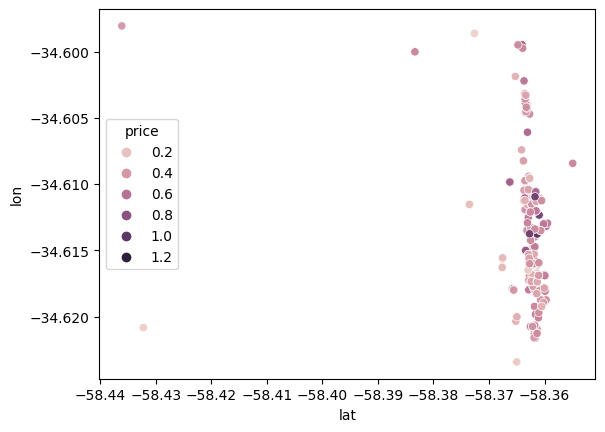

In [370]:
sns.scatterplot(data=df_train[(df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')],x='lat',y='lon',hue='price')

In [371]:
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))&(df_train.lat<-58.42),'lat'] = -58.361
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))&(df_test.lat<-58.4),'lat'] = -58.361

<AxesSubplot: xlabel='lat', ylabel='lon'>

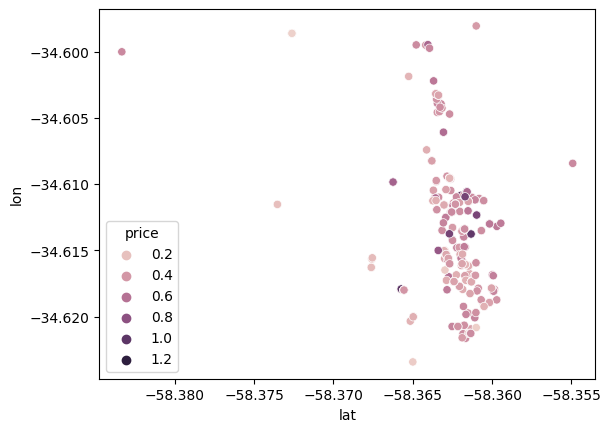

In [372]:
sns.scatterplot(data=df_train[(df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')],x='lat',y='lon',hue='price')

## División de base

In [373]:
df_test_la_plata = df_test[(df_test.lat>-58.2)&(df_test.lon<-34.8)]
df_train_la_plata = df_train[(df_train.lat>-58.2)&(df_train.lon<-34)]

df_test_caba = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&~((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]
df_train_caba = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&~((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]

In [374]:
df_test_madero = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]

df_train_madero = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]

corredor_norte = ['Retiro','Recoleta','Barrio Norte']#,'Nuñez','Distrito Audiovisual','Palermo','Belgrano','Coghlan','Las Cañitas',]

df_train_corredor_norte = df_train_caba[df_train_caba.l3.isin(corredor_norte)]
df_test_corredor_norte = df_test_caba[df_test_caba.l3.isin(corredor_norte)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_norte)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_norte)]

corredor_sur = ['Villa Riachuelo','Villa Lugano','Villa Soldati','Pompeya','Boca','Constitución']#'Barracas','Parque Patricios']

df_train_corredor_sur = df_train_caba[df_train_caba.l3.isin(corredor_sur)]
df_test_corredor_sur = df_test_caba[df_test_caba.l3.isin(corredor_sur)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_sur)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_sur)]

caballito = ['Almagro','Caballito','Parque Centenario','Villa Crespo']

df_train_caballito = df_train_caba[df_train_caba.l3.isin(caballito)]
df_test_caballito= df_test_caba[df_test_caba.l3.isin(caballito)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(caballito)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(caballito)]

palermo = ['Palermo','Distrito Audiovisual','Las Cañitas']
df_train_palermo = df_train_caba[df_train_caba.l3.isin(palermo)]
df_test_palermo= df_test_caba[df_test_caba.l3.isin(palermo)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(palermo)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(palermo)]

belgrano = ['Belgrano','Nuñez','Coghlan']
df_train_belgrano = df_train_caba[df_train_caba.l3.isin(belgrano)]
df_test_belgrano= df_test_caba[df_test_caba.l3.isin(belgrano)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(belgrano)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(belgrano)]

#devoto
df_train_devoto = df_train_caba[df_train_caba.l3=='Villa Devoto']
df_test_devoto = df_test_caba[df_test_caba.l3=='Villa Devoto']

df_train_caba = df_train_caba[df_train_caba.l3!='Villa Devoto']
df_test_caba= df_test_caba[df_test_caba.l3!='Villa Devoto']

In [375]:
ballester_test = df_test[~((df_test.lat<=-58.2)&(df_test.lon>=-34.8))&(df_test.l3.isnull())]

df_test_caba = pd.concat((df_test_caba,ballester_test),axis=0)

### Ajuste de precios (por ahora comentado)

In [376]:
df_train_devoto = df_train_devoto[~((df_train_devoto.l3=='Villa Devoto') &(df_train_devoto.price>=2215000))]

df_train_caba = df_train_caba[~((df_train_caba.l3=='Barracas')&(df_train_caba.title.fillna('NA').str.contains('600000')))]

df_train_belgrano = pd.concat((df_train_belgrano,df_train_caba[df_train_caba.title.fillna('NA').str.contains('Barrancas')]),axis=0)

df_train_caba = df_train_caba[~df_train_caba.title.fillna('NA').str.contains('Barrancas')]


df_train_caba = df_train_caba[~((df_train_caba.l3=='Villa Urquiza')&(df_train_caba.price==3900000.0))]

df_train_madero = pd.concat((df_train_madero,df_train_caba[(df_train_caba.title.fillna('NA').str.contains(' PUERTO MADERO'))]),axis=0)
df_train_caba = df_train_caba[~(df_train_caba.title.fillna('NA').str.contains(' PUERTO MADERO'))]

df_train_madero = pd.concat((df_train_caba[(df_train_caba.l3=='Tribunales')&(df_train_caba.price>2000000)],df_train_madero),axis=0)
df_train_caba = df_train_caba[~((df_train_caba.l3=='Tribunales')&(df_train_caba.price>2000000))]

df_train_caba = df_train_caba[~((df_train_caba.l3=='Boedo')&(df_train_caba.price>3000000))] #TODO: ver si reincorporar
df_train_caba = df_train_caba[~((df_train_caba.l3=='San Cristobal')&(df_train_caba.price>3000000))] #TODO: ver si reincorporar
df_train_caba = df_train_caba[~((df_train_caba.l3=='Centro / Microcentro')&(df_train_caba.price>2000000))] #TODO: ver si reincorporar
df_train_caba = df_train_caba[~((df_train_caba.l3=='Chacarita')&(df_train_caba.price>500000))]#TODO: ver si reincorporar

<AxesSubplot: xlabel='price', ylabel='l3'>

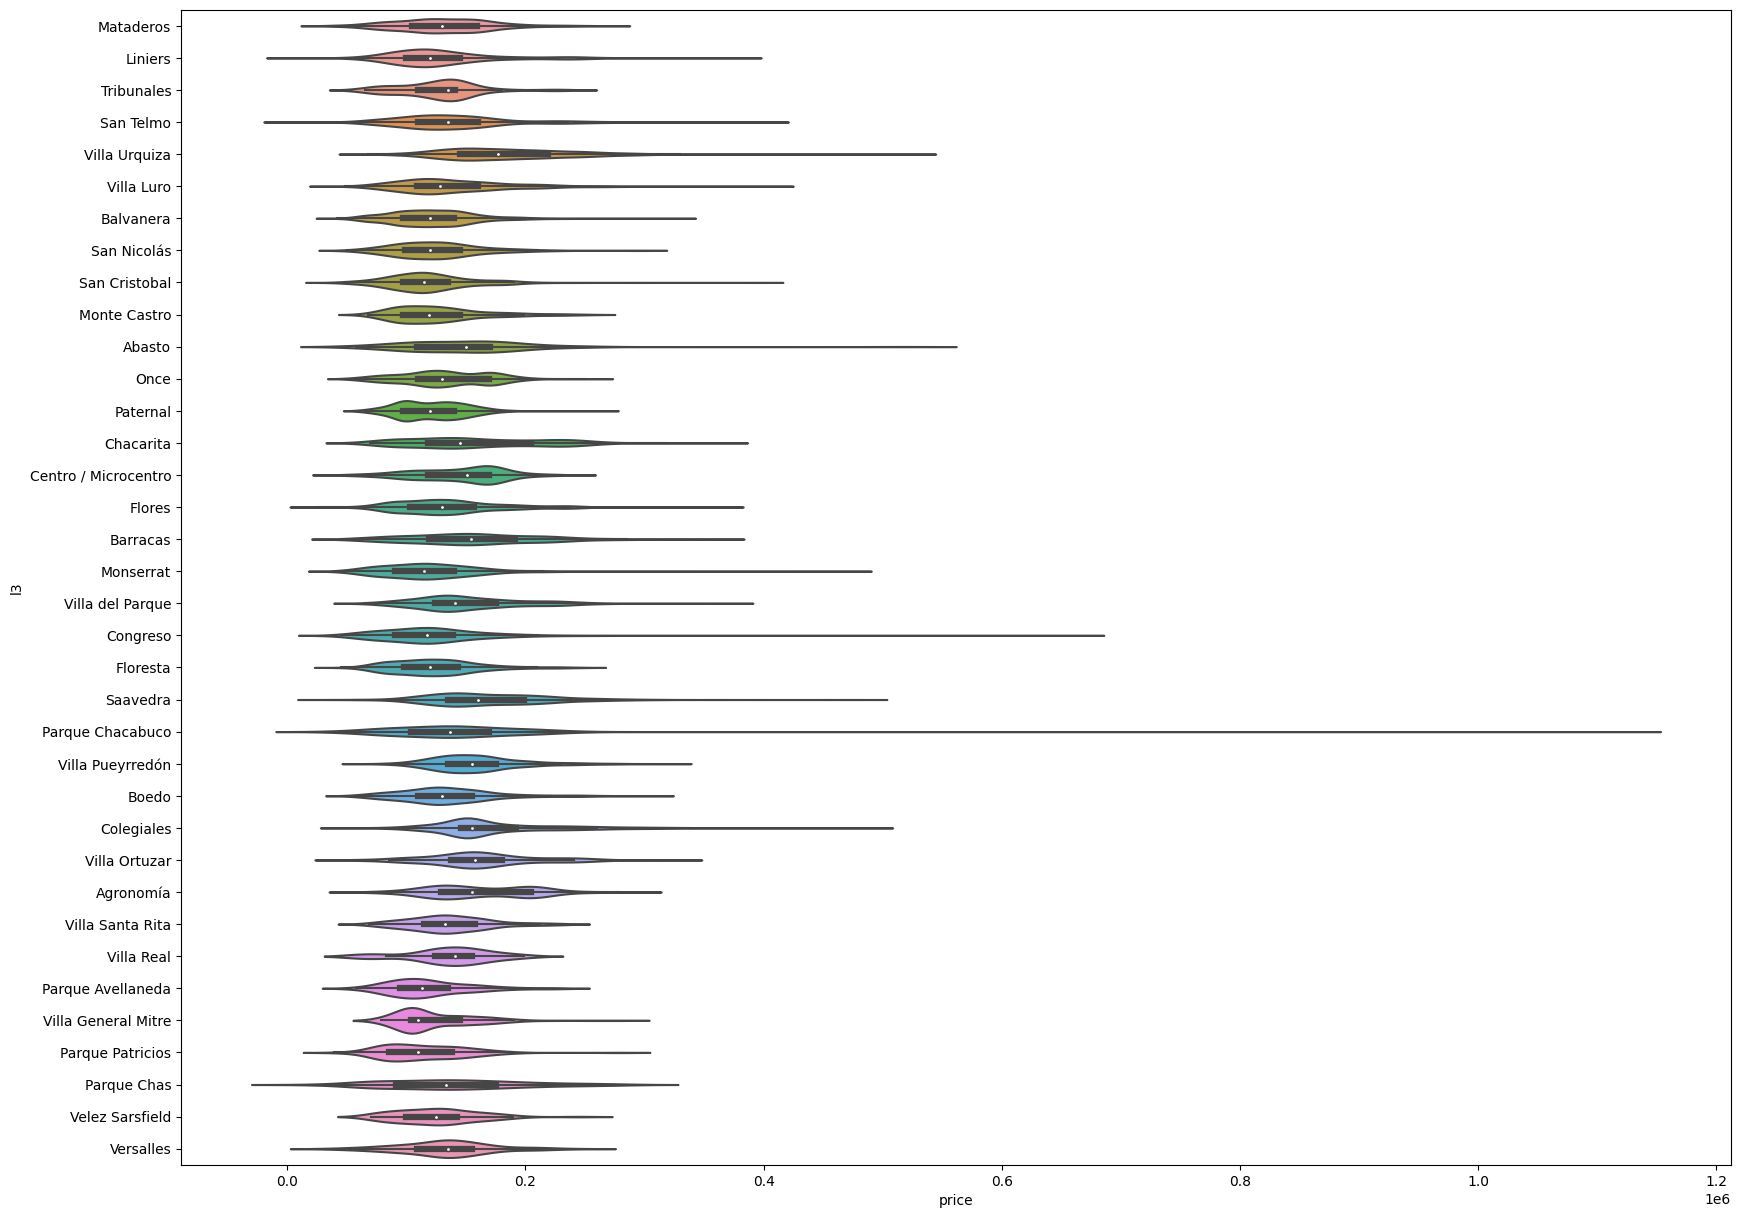

In [377]:
plt.figure(figsize=(20,15))
sns.violinplot(data=df_train_caba,x='price',y='l3')

In [378]:
df_train_palermo.loc[df_train_palermo.price==32434232,'price'] = 32434232/10

In [379]:
df_train_caballito = df_train_caballito[~((df_train_caballito.l3=='Villa Crespo')&
                     (df_train_caballito.price>1200000)&
                     (df_train_caballito.title.str.lower().str.contains('emprendimiento')))]

df_train_caballito = df_train_caballito[~((df_train_caballito.l3=='Caballito')&(df_train_caballito.price>4000000))] #TODO: ver si reincorporar

In [380]:
vale_1111111 = df_train_corredor_sur.price==1111111
vale_1115000 = df_train_corredor_sur.price==1115000
mas_de_800000 = df_train_corredor_sur.price>800000

df_train_corredor_sur.loc[vale_1111111,'price'] = df_train_corredor_sur.loc[vale_1111111,'price']/10
df_train_corredor_sur.loc[vale_1115000,'price'] = df_train_corredor_sur.loc[vale_1115000,'price'] /10
df_train_corredor_sur.loc[mas_de_800000,'price'] = df_train_corredor_sur.loc[mas_de_800000,'price']/10

In [381]:
df_train_madero = df_train_madero[(df_train_madero.price<=4000000)] #TODO: ver si reincorporar en VERSION LAXA
df_train_madero.shape

(372, 82)

<AxesSubplot: xlabel='price', ylabel='l3'>

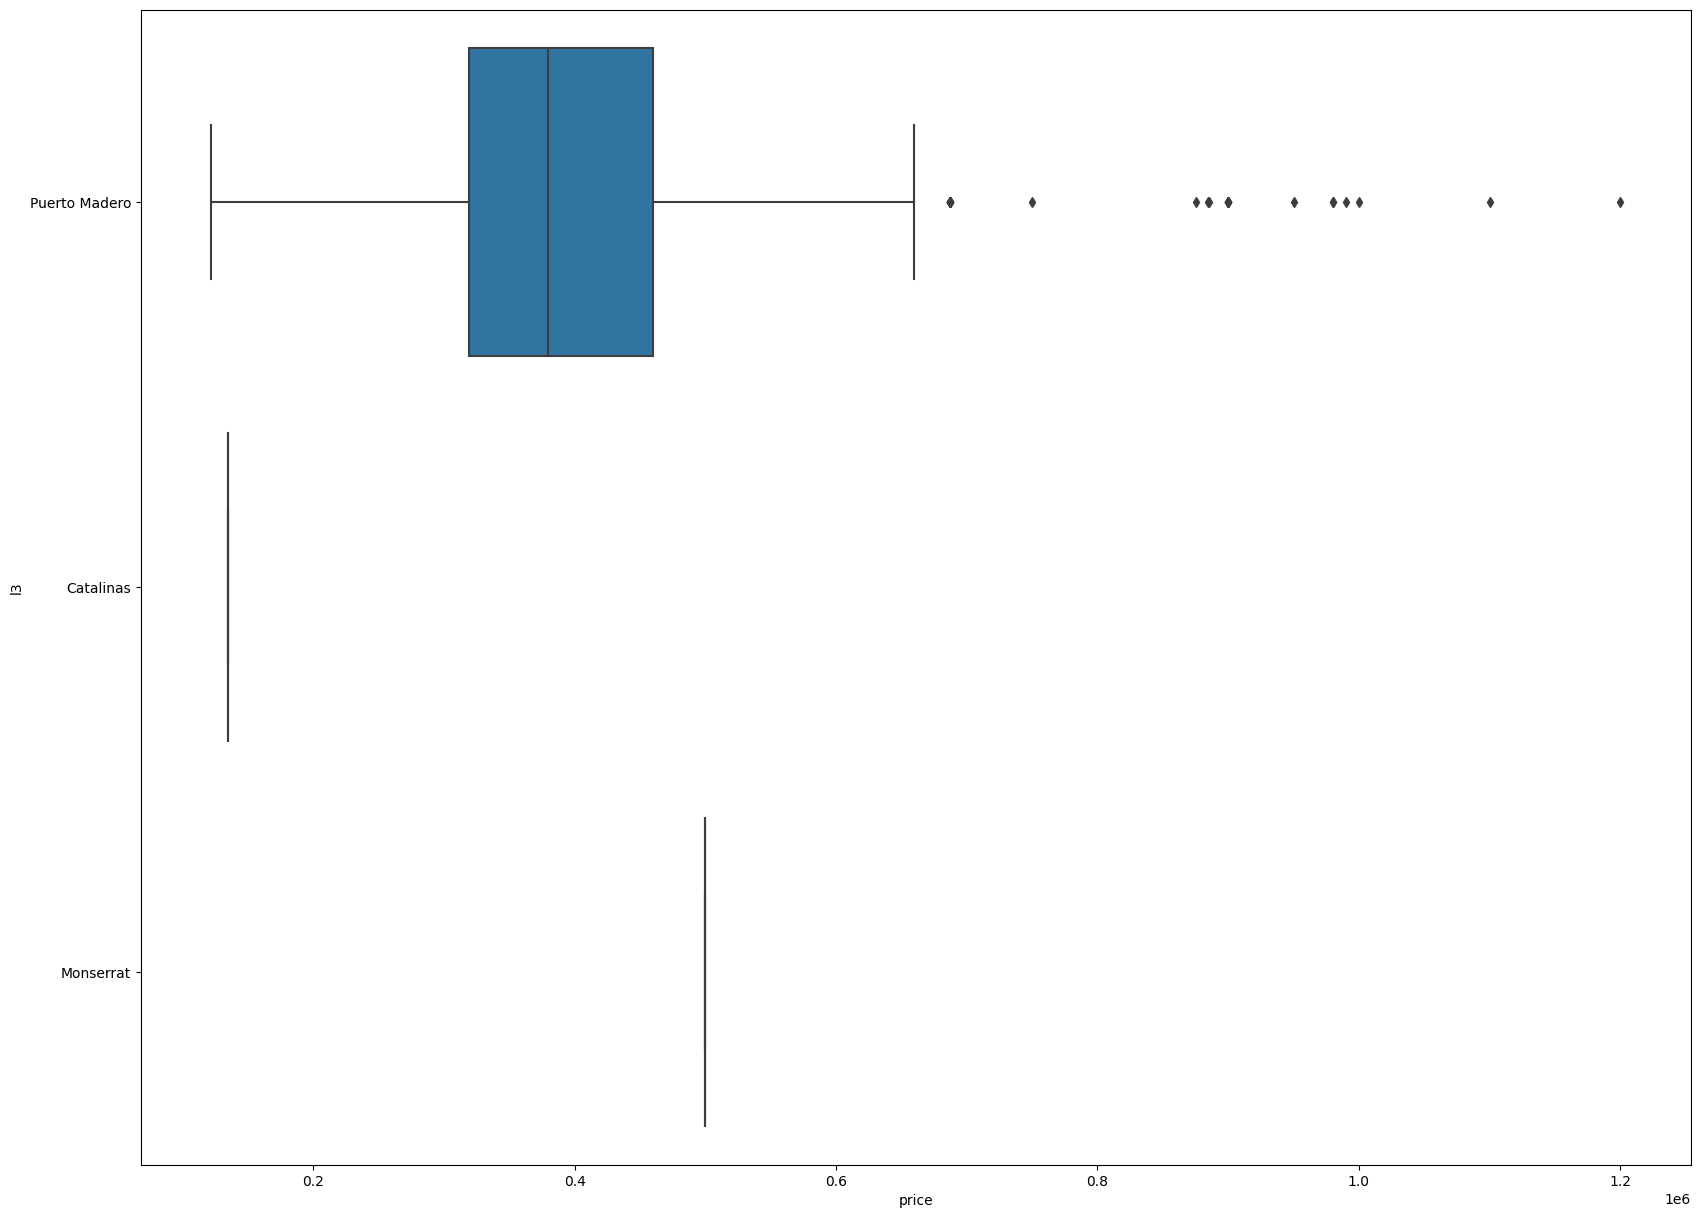

In [382]:
plt.figure(figsize=(20,15))
sns.boxplot(data=df_train_madero,x='price',y='l3')

<AxesSubplot: xlabel='price', ylabel='l3'>

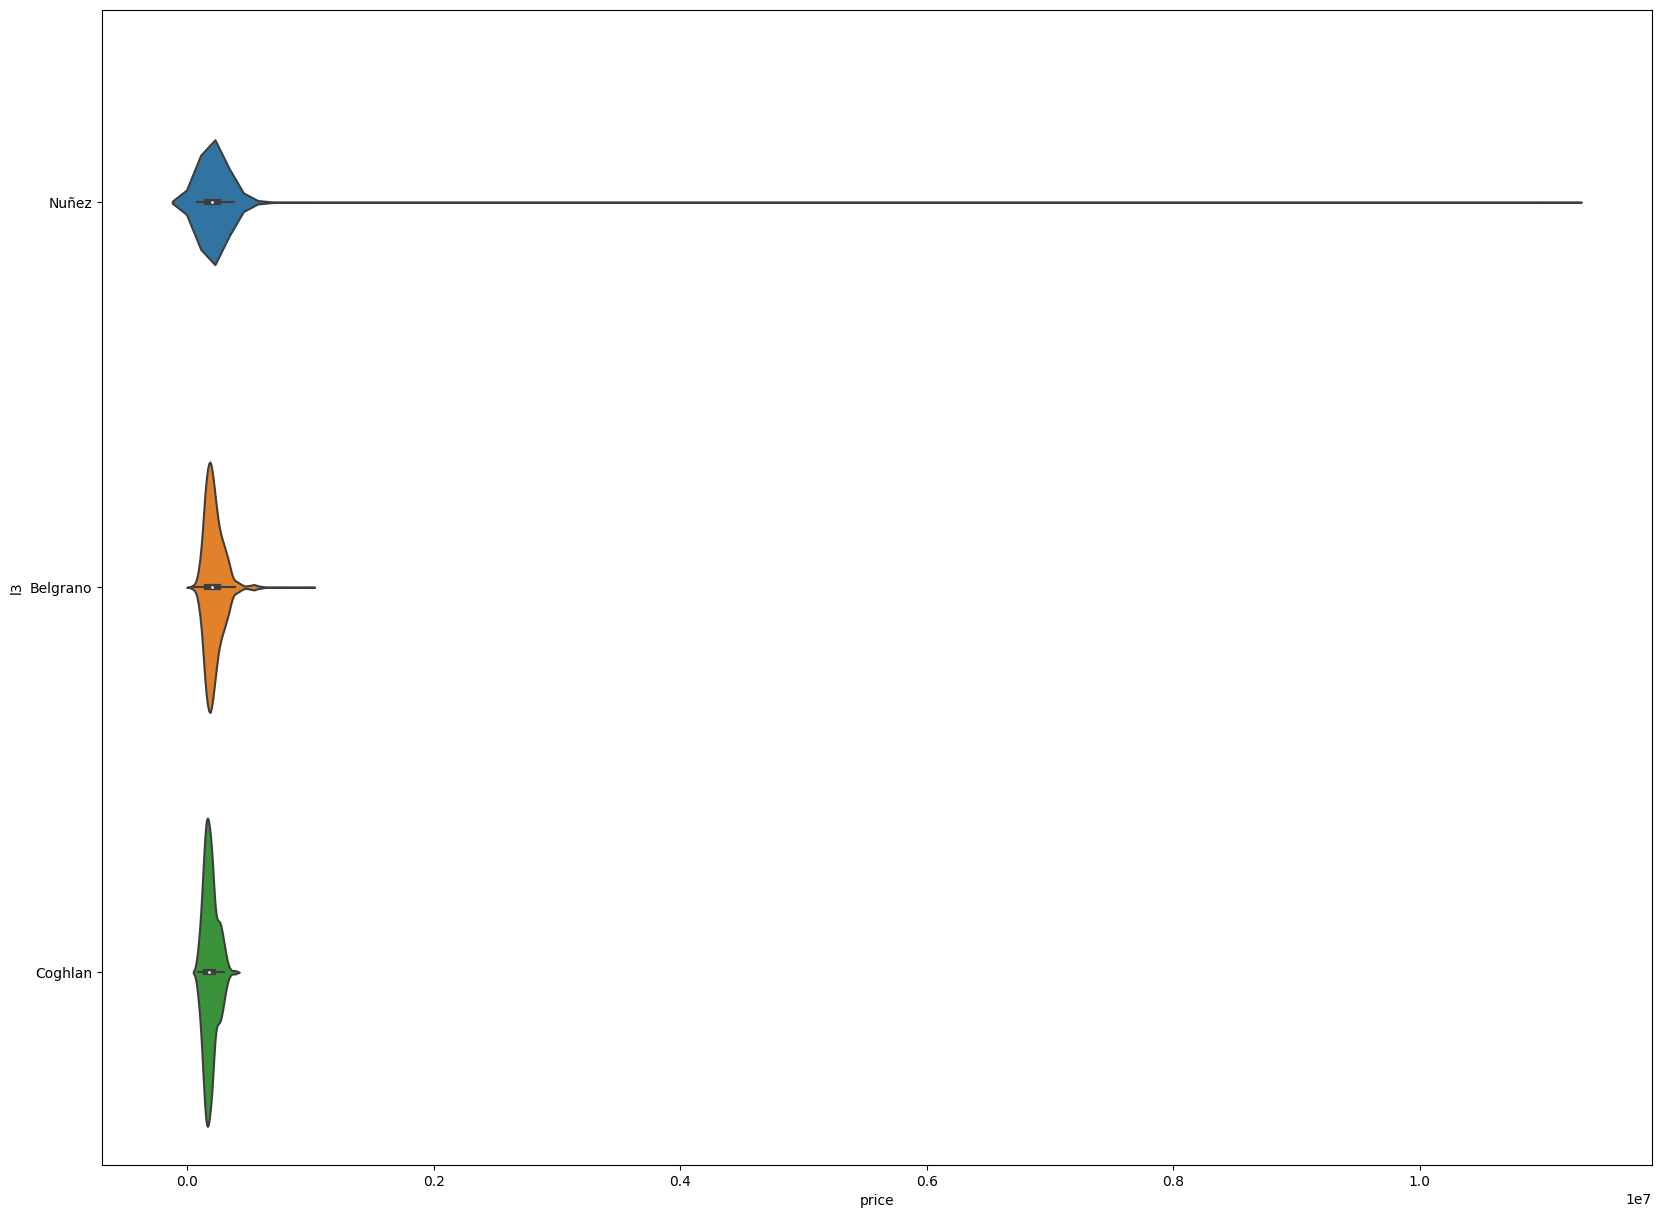

In [383]:
plt.figure(figsize=(20,15))
sns.violinplot(data=df_train_belgrano,x='price',y='l3')

<AxesSubplot: xlabel='price', ylabel='l3'>

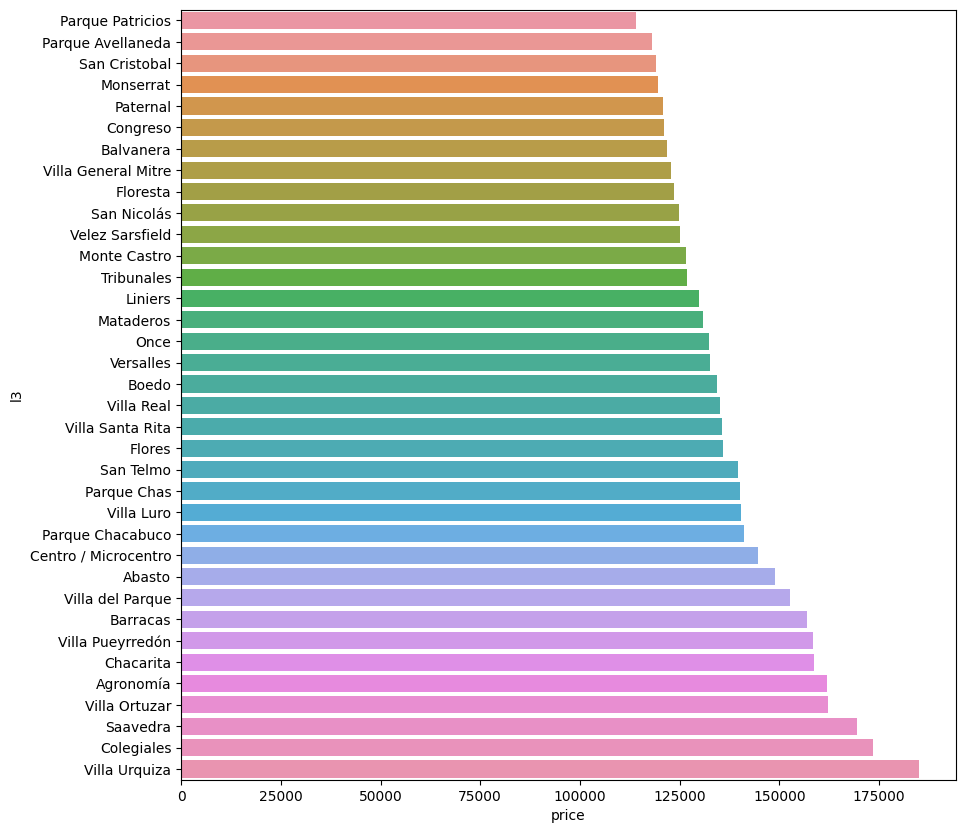

In [384]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=df_train_caba.groupby('l3').agg({'price':'mean'}).reset_index().sort_values('price'),y='l3',x='price')

In [385]:
def filtrado_columnas(df_test,df_train):
    F = df_train[~df_train.price.isnull()]
    X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
    y = F['price']

    clf = sk.ensemble.RandomForestRegressor(n_estimators=50, n_jobs=-1,random_state=42)
    clf.fit(X, y)

    importancias = pd.DataFrame({'atributo': clf.feature_names_in_, 'importancia': clf.feature_importances_})
    cols = list(importancias[importancias['importancia']>0.0001].sort_values('importancia',ascending=False).reset_index(drop=True).atributo)

    cols.append('price')

    display(importancias.sort_values('importancia').tail(10))

    df_train = df_train[cols]
    df_test = df_test[cols]

    print(df_train.shape)
    return df_test, df_train

In [386]:
print(f"La plata tiene {df_train_la_plata.shape[0]} en train y {df_test_la_plata.shape[0]} en test")
print(f"CABA tiene {df_train_caba.shape[0]} en train y {df_test_caba.shape[0]} en test")
print(f"Pto Madero y Catalinas tiene {df_train_madero.shape[0]} en train y {df_test_madero.shape[0]} en test")
print(f"Corr norte tiene {df_train_corredor_norte.shape[0]} en train y {df_test_corredor_norte.shape[0]} en test")
print(f"Corr sur tiene {df_train_corredor_sur.shape[0]} en train y {df_test_corredor_sur.shape[0]} en test")
print(f"Caballito tiene {df_train_caballito.shape[0]} en train y {df_test_caballito.shape[0]} en test")
print(f"Palermo tiene {df_train_palermo.shape[0]} en train y {df_test_palermo.shape[0]} en test")
print(f"Belgrano tiene {df_train_belgrano.shape[0]} en train y {df_test_belgrano.shape[0]} en test")
# print(f"Noroeste tiene {df_train_noroeste.shape[0]} en train y {df_test_noroeste.shape[0]} en test")
print(f"Devoto tiene {df_train_devoto.shape[0]} en train y {df_test_devoto.shape[0]} en test")
# print(f"Barracas tiene {df_train_barracas.shape[0]} en train y {df_test_barracas.shape[0]} en test")

La plata tiene 35 en train y 264 en test
CABA tiene 12137 en train y 2183 en test
Pto Madero y Catalinas tiene 372 en train y 100 en test
Corr norte tiene 2292 en train y 428 en test
Corr sur tiene 690 en train y 111 en test
Caballito tiene 8516 en train y 1373 en test
Palermo tiene 5509 en train y 875 en test
Belgrano tiene 3500 en train y 576 en test
Devoto tiene 546 en train y 90 en test


In [387]:
print("La Plata")
df_test_la_plata, df_train_la_plata = filtrado_columnas(df_test_la_plata,df_train_la_plata)
print("Resto de Caba")
df_test_caba, df_train_caba = filtrado_columnas(df_test_caba,df_train_caba)
print("Madero y Catalinas")
df_test_madero, df_train_madero = filtrado_columnas(df_test_madero,df_train_madero)
print("Corredor Norte")
df_test_corredor_norte, df_train_corredor_norte = filtrado_columnas(df_test_corredor_norte,df_train_corredor_norte)
print("Corredor sur")
df_test_corredor_sur, df_train_corredor_sur = filtrado_columnas(df_test_corredor_sur,df_train_corredor_sur)
print("Caballito")
df_test_caballito, df_train_caballito = filtrado_columnas(df_test_caballito,df_train_caballito)
print("Palermo")
df_test_palermo, df_train_palermo = filtrado_columnas(df_test_palermo,df_train_palermo)
print("Belgrano")
df_test_belgrano, df_train_belgrano = filtrado_columnas(df_test_belgrano,df_train_belgrano)
print("Devoto")
df_test_devoto, df_train_devoto = filtrado_columnas(df_test_devoto,df_train_devoto)

La Plata


,atributo,importancia
5,surface_total,0.031363
19,start_day,0.034608
0,lat,0.035574
16,covered,0.041009
52,desc_av,0.043901
6,surface_covered,0.056076
18,start_month,0.058712
51,desc_av.,0.069816
1,lon,0.198091
11,surface_covered_imputed,0.257506


(35, 36)
Resto de Caba


,atributo,importancia
19,start_day,0.014278
27,desc_parrilla,0.017813
10,surface_total_imputed,0.020250
23,desc_suite,0.022445
58,desc_pileta|piscina,0.023629
16,covered,0.028894
5,surface_total,0.060904
0,lat,0.095346
6,surface_covered,0.228135
1,lon,0.254546


(12137, 62)
Madero y Catalinas


,atributo,importancia
19,start_day,0.010128
65,desc_baulera,0.012618
51,desc_av.,0.013443
23,desc_suite,0.022200
16,covered,0.024313
59,desc_escuela|colegio,0.028489
5,surface_total,0.074066
0,lat,0.123585
1,lon,0.254080
6,surface_covered,0.317084


(372, 53)
Corredor Norte


,atributo,importancia
7,rooms_imputed,0.012880
23,desc_suite,0.027955
16,covered,0.029467
55,desc_a(mm|m)enities,0.032875
10,surface_total_imputed,0.044997
5,surface_total,0.059801
58,desc_pileta|piscina,0.068420
0,lat,0.078400
1,lon,0.164995
6,surface_covered,0.308323


(2292, 58)
Corredor sur


,atributo,importancia
58,desc_pileta|piscina,0.022887
45,desc_jacuzzi,0.031828
55,desc_a(mm|m)enities,0.039383
16,covered,0.044955
6,surface_covered,0.071080
5,surface_total,0.074797
0,lat,0.085990
4,bathrooms,0.093297
14,bathrooms_rooms,0.105789
1,lon,0.161359


(690, 58)
Caballito


,atributo,importancia
29,desc_balcon,0.020153
4,bathrooms,0.025601
14,bathrooms_rooms,0.032530
2,rooms,0.033528
16,covered,0.050207
58,desc_pileta|piscina,0.059618
1,lon,0.086226
5,surface_total,0.091331
0,lat,0.101974
6,surface_covered,0.277612


(8516, 57)
Palermo


,atributo,importancia
11,surface_covered_imputed,0.011922
10,surface_total_imputed,0.013564
14,bathrooms_rooms,0.016102
16,covered,0.035857
0,lat,0.065792
58,desc_pileta|piscina,0.076114
5,surface_total,0.081736
1,lon,0.087043
23,desc_suite,0.144875
6,surface_covered,0.303928


(5509, 59)
Belgrano


,atributo,importancia
7,rooms_imputed,0.031254
64,desc_libertador,0.034360
11,surface_covered_imputed,0.036325
58,desc_pileta|piscina,0.038717
10,surface_total_imputed,0.039025
0,lat,0.064443
5,surface_total,0.092590
6,surface_covered,0.134866
67,desc_emprendimiento,0.193196
1,lon,0.202825


(3500, 58)
Devoto


,atributo,importancia
58,desc_pileta|piscina,0.014561
14,bathrooms_rooms,0.016046
23,desc_suite,0.017642
19,start_day,0.020717
10,surface_total_imputed,0.031534
16,covered,0.036373
0,lat,0.053328
5,surface_total,0.078572
1,lon,0.169304
6,surface_covered,0.350250


(546, 53)


# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [388]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos           
    
    return (X_train, y_train, X_test)

In [389]:
def CV(df_train):
    # Datos para probar
    df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']

    # reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)
    reg = sk.ensemble.GradientBoostingRegressor(n_estimators=500,max_depth=5,random_state=42)
    # Partimos en entrenamiento+prueba y validación
    X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

    scores_train = []
    scores_test = []
    # Validación cruzada, 10 folds, shuffle antes
    kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
        X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

        X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

        # Entrenamos el modelo
        reg.fit(X_train, y_train)

        # Predecimos en train
        y_pred = reg.predict(X_train)

        # Medimos la performance de la predicción en test
        score_train = sk.metrics.mean_squared_error(y_train, y_pred,squared=False).round()
        scores_train.append(score_train)

        # Predecimos en test
        y_pred = reg.predict(X_test)

        # Medimos la performance de la predicción en test
        score_test = sk.metrics.mean_squared_error(y_test, y_pred,squared=False).round()
        scores_test.append(score_test)
        
        print(f"{fold=}, {score_train=} {score_test=}\n")
        

    print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}\n")
    print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}\n")

In [390]:
def modelado(df_train,df_test,n_estimators=500,min_samples_split=2,max_depth=5):
    # reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42,min_samples_split=min_samples_split)
    reg = sk.ensemble.GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,random_state=42)

    ## Datos a predecir 
    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']
    X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

    # Entrenamos el modelo con todos los datos
    reg.fit(X, y)

    # Predecimos
    df_test['price'] = reg.predict(X_prueba)

    # Grabamos
    # df_test['price'].to_csv('solucion_la_plata.csv', index=True)

    print(pd.DataFrame(zip(df_train.columns.drop('price'), 
                             reg.feature_importances_*100), 
                         columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False).head(10).to_markdown())

    return df_test['price']

In [391]:
print("## Resto de CABA\n")
caba_pred = CV(df_train_caba)
print("## La Plata\n")
la_plata_pred = CV(df_train_la_plata)
print("## Puerto Madero y Catalinas\n")
madero_pred = CV(df_train_madero)
print("## Corredor Norte\n")
norte_pred = CV(df_train_corredor_norte)
print("## Corredor Sur\n")
sur_pred = CV(df_train_corredor_sur)
print("## Caballito\n")
cab_pred = CV(df_train_caballito)
print("## Palermo\n")
palermo_pred = CV(df_train_palermo)
print("## Belgrano\n")
bel_pred = CV(df_train_belgrano)
print("## devoto\n")
devoto_pred = CV(df_train_devoto)

## Resto de CABA



fold=0, score_train=16321.0 score_test=30606.0

fold=1, score_train=16320.0 score_test=30862.0

fold=2, score_train=17371.0 score_test=33622.0

fold=3, score_train=17136.0 score_test=28083.0

fold=4, score_train=16229.0 score_test=29582.0

fold=5, score_train=17236.0 score_test=27237.0

fold=6, score_train=16262.0 score_test=27224.0

fold=7, score_train=17370.0 score_test=26515.0

fold=8, score_train=15473.0 score_test=42205.0

fold=9, score_train=16384.0 score_test=29606.0

Train scores mean=16610.2, std=632.7193163902406

Test scores mean=30554.2, std=4614.111586571496

## La Plata

fold=0, score_train=0.0 score_test=28864.0

fold=1, score_train=0.0 score_test=5327.0

fold=2, score_train=0.0 score_test=26978.0

fold=3, score_train=0.0 score_test=14166.0

fold=4, score_train=0.0 score_test=16209.0

fold=5, score_train=0.0 score_test=30543.0

fold=6, score_train=0.0 score_test=0.0

fold=7, score_train=0.0 score_test=4905.0

fold=8, score_train=0.0 score_test=0.0

fold=9, score_train=0.

In [392]:
print("## Resto de CABA\n")
solucion_caba = modelado(df_train_caba,df_test_caba)
print("## La Plata\n")
solucion_la_plata = modelado(df_train_la_plata,df_test_la_plata)
print("## Puerto Madero y Catalinas\n")
solucion_madero = modelado(df_train_madero,df_test_madero)
print("## Corredor Norte\n")
solucion_corredor_norte = modelado(df_train_corredor_norte,df_test_corredor_norte)
print("## Corredor Sur\n")
solucion_corredor_sur = modelado(df_train_corredor_sur,df_test_corredor_sur)
print("## Caballito\n")
solucion_caballito = modelado(df_train_caballito,df_test_caballito)
print("## Palermo\n")
solucion_palermo= modelado(df_train_palermo,df_test_palermo)
print("## Belgrano\n")
solucion_belgrano = modelado(df_train_belgrano,df_test_belgrano)
print("## devoto\n")
solucion_devoto = modelado(df_train_devoto,df_test_devoto)

## Resto de CABA

|    | column                |   feature_importance |
|---:|:----------------------|---------------------:|
|  0 | lon                   |             27.1126  |
|  1 | surface_covered       |             21.68    |
|  2 | lat                   |              9.30172 |
|  3 | surface_total         |              7.96495 |
| 13 | bathrooms_rooms       |              4.22499 |
|  5 | desc_pileta|piscina   |              2.48411 |
|  4 | covered               |              2.47132 |
|  6 | desc_suite            |              2.44152 |
|  7 | surface_total_imputed |              2.18373 |
|  8 | desc_parrilla         |              1.91033 |
## La Plata

|    | column                  |   feature_importance |
|---:|:------------------------|---------------------:|
|  0 | surface_covered_imputed |            47.736    |
|  1 | lon                     |            23.0969   |
|  4 | surface_covered         |            12.3836   |
|  6 | covered                 |         

## Entrega final

In [393]:
pd.concat((solucion_caba,solucion_la_plata,
           solucion_madero,
           solucion_corredor_norte,
           solucion_corredor_sur,
           solucion_caballito,
           solucion_palermo,
           solucion_belgrano,
           solucion_devoto)).to_csv('solucion.csv', index=True)